# EECS 491 - A2 - E3
#### Tristan Maidment - tdm47

## Goal
My goal for this exercise is to facilitate the different methods of denoising images on RGB noise.  Implementations of denoising algorithms will generally be done in the RGB spectrum, for a typical image.  We will be using the Hidden Markov Model (HMM) to determine the most likely pixel value at each point.  Due to the simplicity of the model in the example code, we will be looking at ways to implement floating point denoising.

## Implementation

In [1]:
%matplotlib inline
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import image as imtool
import numpy as np
import random

This function takes a variable list of images and displays them next to each other.  This code came from the example code provided in class.  This will be useful for seeing the difference in image quality while denoising.

In [2]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')
    plt.show()

In order to properly display images using *pyplt*, we must swap the channels around.  By default, OpenCV loads images with channels in the order `b g r`.  We will be using the `r g b` color space.

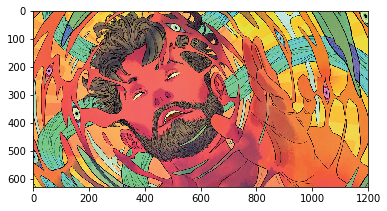

In [3]:
img = cv2.imread('./img.png', 1)
if img is not None:
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
img = img/img.max() #normalize to floats
plt.imshow(img)
plt.show()

For the purpose of this exercise, a high quality image with artifically added noise will be used.  The purpose of this is to be able to quantify the ability to remove the noise.  By having the original image, analysis of the denoising algorithms should be easier.

To add noise to the image, random data is generated using a normal gaussian distribution, with the same dimensions as the original image.  This random data is added to the original image, simulating noise on each pixel (`x,y`) and channel (`z`).  

In order to have the noise properly display, all intensity values must be between `0 - 1`. As such, all values ` > 1` or ` < 0` are set to `1` and `0`, respectively. In addition, the ability to specify the percentage of noise added to the picture has been included.

In [4]:
def add_noise(img, amount, ratio):
    img_noise = img.copy()
    rgb_noise = np.random.normal(0, amount, img_noise.shape)
    index = np.random.rand(img_noise.shape[0], img_noise.shape[1], img_noise.shape[2])
    img_noise[index < ratio] += rgb_noise[index < ratio]
    img_noise[img_noise > 1.] = 1.
    img_noise[img_noise < 0.] = 0.
    return img_noise

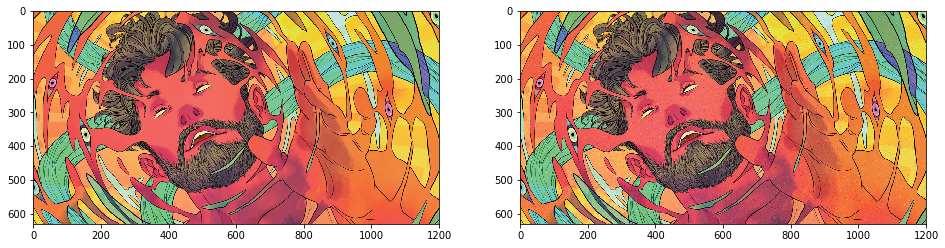

In [5]:
img_noise = add_noise(img, 0.1, 0.1)
showimgs(img, img_noise)

A visual representation of the noise can be seen by taking the difference of the two pictures.  Note that the contrast of the noise has been enhanced, in order to show better detail in the noise.

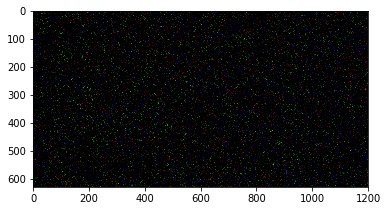

In [6]:
difference = np.absolute(img_noise - img)
plt.imshow(difference/difference.max())
plt.show()

The definition of the energy function is the same as the one used in the example.  The `dE` term is not fully accurate, as it assumes a flipped pixel instead of an average or decremented pixel, but should approximate the gradient well enough.

In [7]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    kernel = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    matB = cv2.filter2D(hidden, -1, kernel)
    
    mapE = hidden * (alpha - beta * matB - eta * observation)

    E = np.mean(mapE)
    
    dE = -2 * mapE
    
    return E, dE

In order to denoise RGB images, a method for changing the channel intensities must be defined.  

For this attempt, we will be denoising by decreasing the channel intensities.  This should decrement each channel seperately, since the energy function is calculated per channel.  This should allow for more accurate denoising, due to more information being utilized.

In an attempt to prevent this method from decrementing the intensity too far, the amount that the pixel is decreased is exponentially smaller each iteration.  This should allow for more fine tuned denoising.

In [8]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E and i <= 50:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] -= (i+1) * 0.1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    return imrec

We run the `denoise` function and compare the output.

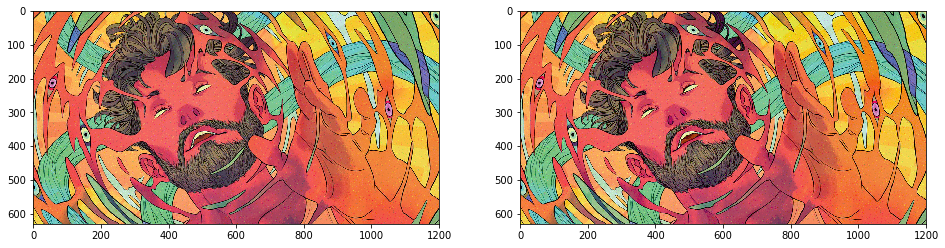

In [9]:
imrec = denoise(img_noise, defaultEnergyFunction)
imrec = np.absolute(imrec/imrec.max())
showimgs(img_noise, imrec)

The difference between the two functions is shown below.  To illustrate the RGB channel denoising, the contrast has been increased.

It is interesting to notice that the noise removed from the face, which is primarly red, is mostly green.  This is notable due to the fact that green is opposite to red on the color wheel, indicating a large energy.  Furthermore, it appears as though the denoising removes edges fairly often, which is as expected.

The yellow/orange areas have had a lot of blue noise removed.  Again, this is interesting because they are also opposite colors.  This confirms that the energy in those channels would be exceedingly high, due to the lack of other blue pixels.

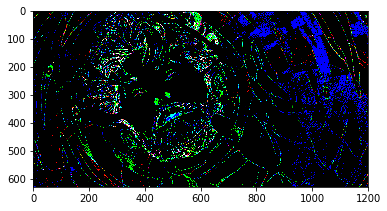

In [10]:
imdiff = np.absolute(img_noise - imrec)
plt.imshow(imdiff/imdiff.max())
plt.show()

In an attempt to improve the quality of the denoising function, it has been modified to take the average pixel value instead of decrementing the intensity.  To implement this easily with minimal runtime, the convolution of the kernel is computed at each step in the gradient descent.  This allows for an efficient way to set the pixel value based on it's neighbors.

In [11]:
def denoise(imnsy, efunc):
    imrec = imnsy.copy()
    
    E, dE = efunc(imrec, imnsy)

    Etmp, i = E + 1, 0

    kernel = np.asarray([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])
    
    while Etmp > E and i <= 10:
        Etmp = E
        
        imgconv = cv2.filter2D(imrec, -1, kernel)

        imrec[dE < 0] += 0.01 * imgconv[dE < 0]

        E, dE = efunc(imrec, imnsy)

        i += 1
        
    return imrec

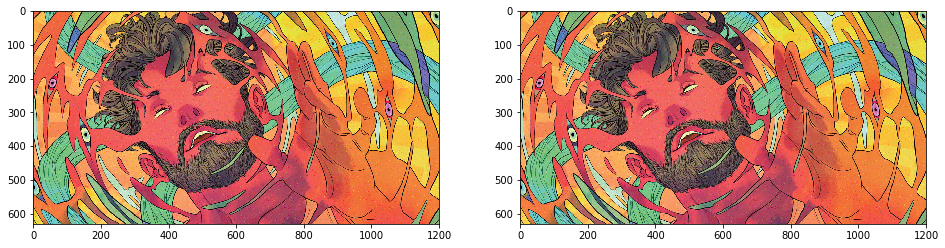

In [12]:
imrec = denoise(img_noise, defaultEnergyFunction)
imrec = np.absolute(imrec/imrec.max())
showimgs(img_noise, imrec)

As we can see, the same traits in terms of pixel removal exist from the first example.  However, the pixels have been averaged, resulting in a more uniform distribution of intensities along each channel.  As a result, the difference of the two images is less intense.

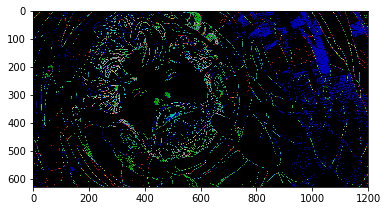

In [13]:
imdiff = np.absolute(img_noise - imrec)
plt.imshow(imdiff/imdiff.max())
plt.show()

Next, the kernel was expanded from the four closest neighboring pixels to include the four diagonal neighbors, in an attempt to get a better estimation of the hidden pixel value.

In [14]:
def denoise(imnsy, efunc):
    imrec = imnsy.copy()
    
    E, dE = efunc(imrec, imnsy)

    Etmp, i = E + 1, 0

    kernel = np.asarray([[0.125, 0.125, 0.125], [0.125, 0, 0.125], [0.125, 0.125, 0.125]])
    
    while Etmp > E and i <= 10:
        Etmp = E
        
        imgconv = cv2.filter2D(imrec, -1, kernel)

        imrec[dE < 0] += 0.01 * imgconv[dE < 0]

        E, dE = efunc(imrec, imnsy)

        i += 1
        
    return imrec

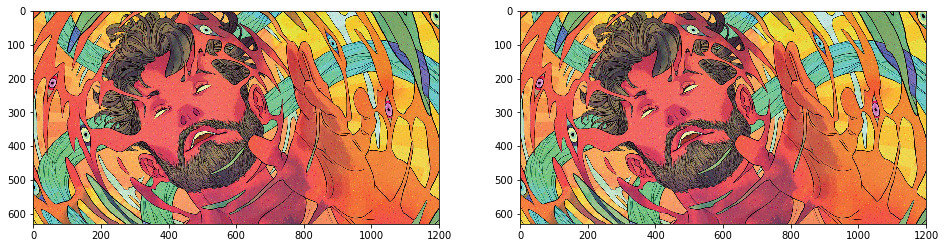

In [15]:
imrec = denoise(img_noise, defaultEnergyFunction)
imrec = np.absolute(imrec/imrec.max())
showimgs(img_noise, imrec)

As we can see, there is more variance, again, in the intensity of pixels changed.  This indicates that the set pixel have a higher range of intensities, and, as a result, provide a more accurate representation of the hidden pixel.

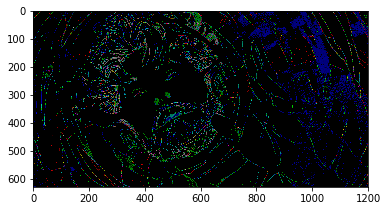

In [16]:
imdiff = np.absolute(img_noise - imrec)
plt.imshow(imdiff/imdiff.max())
plt.show()

## Conclusion

In conclusion, the ability to denoise multi-channel images was achieved, and the energy function properly responds to the intensity differences in each channel. In addition, the ability to denoise floating point images (since each channel is in the range `0. - 1.` was explored, and the use of the convolution function was used to determine the most probable pixel value, based on its neighbors.